# DS210 - DeepLearning Sentiment Portfolio (DSP)
## Deep Learning Model Deploy
### Irene Na

## Set the environment

In [1]:
# !pip install --upgrade wrds --quiet
# !pip install  --upgrade openpyxl -- quiet
# !pip install yfinance --quiet
!pip install PyPortfolioOpt --quiet
!pip install cvxopt --quiet
!pip install cvxpy --quiet
# !pip install openpyxl --quiet
# !pip install tensorboard -- quiet
# !pip install optuna --quiet

# import wrds
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import pickle
import seaborn as sns
# import yfinance as yf
import importlib
# from statsmodels.regression.rolling import RollingOLS
# import statsmodels.api as sm
# import statsmodels.formula.api as smf
from pypfopt import (
    EfficientFrontier,
    risk_models,
    plotting,
    # fix_nonpositive_semidefinite
)
import cvxpy as cp
import warnings
# warnings.filterwarnings("ignore")
warnings.filterwarnings('default')
from sklearn.covariance import LedoitWolf
from joblib import Parallel, delayed

import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset

# import openpyxl
# print(openpyxl.__version__)

# from torch.utils.tensorboard import SummaryWriter
# import optuna

import pdb
# pdb.set_trace() 
from torch.utils.data import ConcatDataset
# import torch.multiprocessing as mp
# import torch.distributed as dist
import s3fs
fs = s3fs.S3FileSystem()
import gc
import logging
import joblib

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics.pairwise import cosine_similarity

# from torch.utils.data import Subset
from datetime import datetime

# display(cp.installed_solvers())

## Functions

In [31]:
def regression_sm(df_y, df_x):
    idx1 = df_x.dropna(how='all').index
    idx2 = df_y.dropna(how='all').index

    index_comm = idx1.intersection(idx2, sort=False)
    df_Y = df_y.reindex(index_comm)
    df_X = df_x.reindex(index_comm)

    x, y = df_X, df_Y
    x = sm.add_constant(x, has_constant='add')
    model_prefit = sm.OLS(y,x)
    sm_model = model_prefit.fit()
    param_reg = sm_model.params
    return x, y, sm_model, model_prefit, param_reg

def optimizer_ef(ann_exp_exc_rtn, ann_cov_matrix, opt_flag, target_risk,
                 solver_name='CLARABEL', market_neutral=False, risk_free_rate=None):
    ef_ob = EfficientFrontier(ann_exp_exc_rtn, ann_cov_matrix)
    ef_ob._solver = solver_name # IN: 'CLARABEL', this solver works for max_sharpe choice, and likely better for 'target_risk' too
    # ef_ob._solver_options ={'ECOS':cp.ECOS}
    # ef_ob._solver = 'ECOS'

    if opt_flag == 'target_risk':
        ef_ob.efficient_risk(target_volatility=target_risk, market_neutral=market_neutral)
    elif opt_flag == 'max_sharpe':
        if risk_free_rate:
            # print ('here')
            # ef_ob.risk_free_rate = risk_free_rate # set risk free rate as zero; default: 0.02 in def max_sharpe(self, risk_free_rate=0.02)
            ef_ob.max_sharpe(risk_free_rate = risk_free_rate)
        else:
            ef_ob.max_sharpe()

    return ef_ob.clean_weights()

def prep_rank_feature(df, features_col, shift_d):

    rank_features_col_lag = [x+'_rank' for x in features_col]
    rank_feat = df.set_index(['date','permno'])[features_col].groupby('date')\
        .apply(lambda x: (x.rank(pct=True)-0.5).droplevel(0))\
            .rename(columns=dict(zip(features_col, rank_features_col_lag))).reset_index()
    # regroup by stock and do the shift
    rank_feat = rank_feat.set_index('date').groupby('permno')[rank_features_col_lag]\
        .apply(lambda x: x.shift(shift_d)).reset_index()

    df = pd.merge(df, rank_feat, on=['date','permno'], how='left')

    return df, rank_features_col_lag

def mmd_cal(df, return_col_name):
    df_0 = df.copy()
    df_0['cum_rtn']=(1+df_0[return_col_name]).cumprod()
    df_0['drawdown'] = (df_0['cum_rtn']-df_0['cum_rtn'].cummax())/df_0['cum_rtn'].cummax()
    df_0['max_drawdown'] =  df_0['drawdown'].cummin()
    return df_0['max_drawdown']

def portfolio_performance(input_df, weight_df, portf_name, rebal_freq, mkt_df, 
                          last_win_only=False, vol_scaler_flag=False, scaling_vol_tgt=0.3, plot_show=True): #IN mod
    # rebal_freq: 'D','M','W'
    if rebal_freq =='D':
        ff_n = 2
    elif rebal_freq == 'W':
        ff_n = 7
    elif rebal_freq == 'M':
        ff_n = 31
        
    if last_win_only is True: #IN mod, if it's last_win_only mode (demo mode), only use last year data, and backfill the weights 
       return_df = input_df[input_df['date'].dt.year.isin([2024])].set_index(['date','permno'])['return'].unstack()[weight_df.columns]
       weight_df=weight_df.asfreq('D').ffill(limit=ff_n).reindex(return_df.index)\
        .ffill().bfill().where(~(return_df.isnull()), 0)
       mkt_df = mkt_df.loc[return_df.index,:]
    else: 
        return_df = input_df.set_index(['date','permno'])['return'].unstack()[weight_df.columns]
        weight_df=weight_df.asfreq('D').ffill(limit=ff_n).reindex(return_df.index).where(~(return_df.isnull()), 0)
    portf_rtn = (return_df*weight_df).sum(axis=1)

    if vol_scaler_flag is True:
        portf_rtn_0 = portf_rtn.copy()
        if (last_win_only is True) or (portf_rtn.index[0]>=datetime.strptime('2021-01-01', '%Y-%m-%d')): #IN mod5
            portf_rtn = (portf_rtn_0*(scaling_vol_tgt/np.sqrt(252))/(portf_rtn_0.rolling(60, min_periods=20).std())) 
        else: 
            portf_rtn = portf_rtn_0*(scaling_vol_tgt/np.sqrt(252))/(portf_rtn_0.rolling(60).std())
        scaler_df = portf_rtn.div(portf_rtn_0, axis=0)
        # scaled_mkt = mkt_df['return_sp']*scaling_vol_tgt/mkt_df['return_sp'].rolling(60).std()
        # unscaled_mkt = mkt_df['return_sp']
        unscaled_mkt = mkt_df['return_sp'].loc[portf_rtn.index[0]:]

    else:
        scaler_df = portf_rtn.div(portf_rtn, axis=0)
        # scaled_mkt = mkt_df['return_sp']*(portf_rtn.rolling(60).std()/mkt_df['return_sp'].rolling(60).std())
        # unscaled_mkt = mkt_df['return_sp']
        unscaled_mkt = mkt_df['return_sp'].loc[portf_rtn.index[0]:]
    
    fig1, ax1 = plt.subplots(1,2, figsize=(11,3.5))
    portf_mkt_rtn = pd.concat([portf_rtn.rename(portf_name), unscaled_mkt.rename('Unscaled Market')], axis=1)
    portf_mkt_rtn.cumsum().plot(ax=ax1[0])
    ax1[0].set_title(f'Cumulative Return Comparison')
    ax1[0].legend(loc='upper left')
    # plt.legend()
    # plt.show()
    ax1[0].set_ylabel('Cumulative Return') #IN mod3

    if last_win_only is True:
        (portf_mkt_rtn.rolling(60).std()*np.sqrt(252)).plot(
            ax=ax1[1],
            title='Rolling Annual Vol Comparison')
        ax1[1].legend(bbox_to_anchor=(1,1))
    else:
        (portf_mkt_rtn.rolling(252).std()*np.sqrt(252)).plot(
        ax=ax1[1],
        title='Rolling Annual Vol Comparison')
        ax1[1].legend(bbox_to_anchor=(1,1))
    ax1[1].set_ylabel('Rolling Annual Vol') #IN mod3

    fig1.suptitle(f'{portf_name} vs (Unscaled) S&P500 Cumulative Return and Rolling Vol Comparison')
    plt.subplots_adjust(top=0.85, bottom=0.01, wspace=0.2)
    if plot_show is True: #IN mod
        plt.show()
    plt.close()

    stats_df = pd.DataFrame(columns=portf_mkt_rtn.columns)
    stats_df.loc['avg_rtn_ann',:] = portf_mkt_rtn.mean()*252
    stats_df.loc['vol_ann',:] = portf_mkt_rtn.std()*np.sqrt(252)
    stats_df.loc['sharpe_ann',:] = stats_df.loc['avg_rtn_ann',:]/stats_df.loc['vol_ann',:]
    stats_df.loc['max_drawdown',portf_name] = mmd_cal(portf_mkt_rtn, portf_name).iloc[-1]
    stats_df.loc['max_drawdown','Unscaled Market'] = mmd_cal(portf_mkt_rtn, 'Unscaled Market').iloc[-1]
    
    if plot_show is True: #IN mod
        print(stats_df)    

    return portf_rtn, portf_mkt_rtn, stats_df, scaler_df, fig1

def performance_comparison_all_recal(portf_rtn_df_l, mkt_rtn,\
                               rebal_freq, last_win_only=False, plot_show=True):
    # by the process the portf series should already have unique names except unscaled mkt
    portf_mkt_rtn_comb = pd.concat(portf_rtn_df_l + [mkt_rtn], axis=1)

    fig1, ax1 = plt.subplots(1,2, figsize=(11,3.5))
    
    # portf_mkt_rtn = pd.concat([portf_rtn.rename(portf_name), unscaled_mkt.rename('Unscaled Market')], axis=1)
    portf_mkt_rtn_comb.cumsum().plot(ax=ax1[0])
    ax1[0].set_title(f'Cumulative Return Comparison')
    ax1[0].legend(loc='upper left')
    ax1[0].set_ylabel('Cumulative Return') #IN mod3
    
    # if last_win_only is True:
    if portf_mkt_rtn_comb.index[0]>=datetime.strptime('2021-01-01', '%Y-%m-%d'):
        (portf_mkt_rtn_comb.rolling(60).std()*np.sqrt(252)).plot(
            ax=ax1[1],
            title='Rolling Annual Vol Comparison')
        ax1[1].legend(bbox_to_anchor=(1,1))
    else:
        (portf_mkt_rtn_comb.rolling(252).std()*np.sqrt(252)).plot(
        ax=ax1[1],
        title='Rolling Annual Vol Comparison')
        ax1[1].legend(bbox_to_anchor=(1,1))
    ax1[1].set_ylabel('Rolling Annual Vol') #IN mod3

    if (len(portf_mkt_rtn_comb.loc['2021-01-01':,:])>0) and last_win_only is False: 
        ax1[0].axvline(x='2020-12-31', color='red', linestyle='--', linewidth=1.5, label='Train vs Test Division')
        ax1[1].axvline(x='2020-12-31', color='red', linestyle='--', linewidth=1.5, label='Train vs Test Division')
        ax1[0].legend(loc='upper left')
        ax1[1].legend(bbox_to_anchor=(1,1))
        
    fig1.suptitle(f'Proposed Portforlio ({rebal_freq}) vs (Unscaled) S&P500 Cumulative Return and Rolling Vol Comparison')
    plt.subplots_adjust(top=0.85, bottom=0.01, wspace=0.2)
    if plot_show is True: #IN mod
        plt.show()
    plt.close()

    # recalculate stats table
    stats_df_comb = pd.DataFrame(columns=portf_mkt_rtn_comb.columns)
    stats_df_comb.loc['avg_rtn_ann',:] = portf_mkt_rtn_comb.mean()*252
    stats_df_comb.loc['vol_ann',:] = portf_mkt_rtn_comb.std()*np.sqrt(252)
    stats_df_comb.loc['sharpe_ann',:] = stats_df_comb.loc['avg_rtn_ann',:]/stats_df_comb.loc['vol_ann',:]

    for col in portf_mkt_rtn_comb.columns:
        stats_df_comb.loc['max_drawdown',col] = mmd_cal(portf_mkt_rtn_comb, col).iloc[-1]

    # stats_df_comb = stats_df_comb.T.sort_values(by='sharpe_ann', ascending=False).T
    
    if plot_show is True:
        print(stats_df_comb)
    
    return portf_mkt_rtn_comb, stats_df_comb, fig1
    

def check_weights_plots(opt_weight_df):
    # check basic properties for optimization weights:
    np.round(opt_weight_df.sum(axis=1),2).plot(title='Total weights for the portfolio over time', figsize=(5,3))
    plt.show()

    opt_weight_df.count(axis=1).plot(title='Total number of stocks over time (not all have non zero weight)', figsize=(5,3))
    plt.show()

    opt_weight_df[opt_weight_df>0].count(axis=1).plot(title='Total number of stocks with non-zero weight over time', figsize=(5,3))
    plt.show()


def load_train_val_dataset(model_dir, version_no, is_s3=False):
    # full_dir = f'{model_dir}{model_checkpoint}/{rebal_freq}/' ## for sm ; folder: 'monthly', 'weekly', 'daily'

    if is_s3:
        with fs.open(f'{model_dir}train_dataset_dl_{version_no}.pkl', 'rb') as f:
            train_dataset = pickle.load(f)
        with fs.open(f'{model_dir}val_dataset_dl_{version_no}.pkl', 'rb') as f:
            val_dataset = pickle.load(f)
    else:
        with open(f'{model_dir}train_dataset_dl_{version_no}.pkl', 'rb') as f:
            train_dataset = pickle.load(f)
        with open(f'{model_dir}val_dataset_dl_{version_no}.pkl', 'rb') as f:
            val_dataset = pickle.load(f)

    return train_dataset, val_dataset


def load_test_dataset(model_dir, version_no, is_s3=False):
    # full_dir = f'{model_dir}{model_checkpoint}/{rebal_freq}/' ## for sm ; folder: 'monthly', 'weekly', 'daily'
    if is_s3:
        with fs.open(f'{model_dir}test_dataset_dl_{version_no}.pkl', 'rb') as f:
            test_dataset = pickle.load(f)
    else:
        with open(f'{model_dir}test_dataset_dl_{version_no}.pkl', 'rb') as f:
            test_dataset = pickle.load(f)
    return test_dataset

### Classes

In [3]:
class DL_dataset(Dataset):
    def __init__(self, initial_data, rebal_freq, window_days, feature_cols, tgt_cols):
        self.data = []
        self.dates = []  # the dates corresponding to the sample (x,y)
        self.permnos = [] # the list of permno_id whose returns are predicted for each rebal date
        self.rebal_freq = rebal_freq # IN: 'D', 'W', 'M'
        if (initial_data['date'].unique()[0].year == 2000)&\
                initial_data['date'].unique()[0].month == 1:
            self.dates_daily = initial_data['date'].unique()[20:]
            # the first available date for features is the first date of the second month of all data
        else:
            self.dates_daily = initial_data['date'].unique()
        self.dates_weekly = pd.Series(np.ones(len(self.dates_daily)), \
                               index=pd.DatetimeIndex(self.dates_daily)).asfreq('W-WED').index
        self.dates_monthly = pd.Series(np.ones(len(self.dates_daily)), \
                                index=pd.DatetimeIndex(self.dates_daily)).asfreq('ME').index
        self.window_days = window_days
        self.feature_cols = feature_cols
        self.tgt_cols = tgt_cols

        # create rolling windows group by date across different stocks
        if self.rebal_freq == 'D':
            self.rebal_dates = self.dates_daily
        elif self.rebal_freq == 'W':
            self.rebal_dates = self.dates_weekly
        elif self.rebal_freq == 'M':
            self.rebal_dates = self.dates_monthly

        initial_data = initial_data.sort_values(['date','permno'])
        #just to make sure it's in the right order but it should already been

        for i, date in enumerate(self.rebal_dates):
            if i%252==0:
                print (date)
            ''' create rolling samples'''

            index_in_daily_dates = list(self.dates_daily).index(self.dates_daily[self.dates_daily<=date][-1])

            date_period = self.dates_daily[max(0,(index_in_daily_dates+1)-self.window_days*1)
                                        :max(self.window_days*1, (index_in_daily_dates+1))]
            # extract rolling window data
            data_t = initial_data[initial_data['date'].isin(date_period)][self.feature_cols+['date','permno']]

            ## prepare the Y data
            # df_x = data_t[sel_features_adj].apply(lambda x: x*data_t['prev_d_exc_ret'], axis=0).ffill()
            if rebal_freq == 'M':
                match_date = self.dates_daily[(self.dates_daily.month==date.month)
                                            &(self.dates_daily.year==date.year)][-1]
            elif rebal_freq == 'W':
                match_date = self.dates_daily[(self.dates_daily<=date)][-1]
            else:
                match_date = date

            target_data = initial_data[initial_data['date']==match_date][['permno']+self.tgt_cols].sort_values('permno')
            # regulate the number of stocks per day as the same for later modeling purpose (e.g. transformer need inputs are of same dimension)
            if len(target_data)<500:
                pad_df = pd.DataFrame(np.ones((500-len(target_data),len(target_data.columns))),
                                      columns = target_data.columns,
                                        index = list(500 + np.arange(500-len(target_data))))
                target_data = pd.concat([target_data, pad_df])
            else:
                target_data = target_data.iloc[:500,:] # if target_data has >=500 rows, only take the first 500 rows

            y = target_data[self.tgt_cols].values # shape: (num_stocks,)
            permnos_t = target_data['permno'].tolist()

            # convert y to torch tensor
            y = torch.tensor(y, dtype=torch.float32).nan_to_num()
            # y = torch.tensor(y*100, dtype=torch.float32).nan_to_num() #blow up the magnitude and see if that helps
            # print('/t')
            # print (y)

            ## prepare the X data
            # pivot so that each stock has its own row, with window_days sequences as columns (values are the multiple columns)
            data_t_adj = data_t[data_t['permno'].isin(permnos_t)]
            pivoted_data_t = data_t_adj.pivot(index='permno', columns='date')

            # reshape the pivoted_data
            X = pivoted_data_t.values.reshape(pivoted_data_t.shape[0], len(date_period), -1)
            # using len(date_period) instead of just the window_days, just in case certain period have odd days at the start or end period

            # to make sure X have the same shapes for later processing, padding to 500, 252 to dimension 0 and 1 (latter may not be needed)
            if pivoted_data_t.shape[0]<500:
                n_pad_0 = 500-pivoted_data_t.shape[0]
                X = np.pad(X, ((0, n_pad_0), (0, 0), (0, 0)), mode='constant', constant_values=0)
            # if pivoted_data_t.shape[1]<252:
            #     n_pad_1 = 252 - pivoted_data_t.shape[1]
            #     X = np.pad(X, ((0, 0), (0, n_pad_1), (0, 0)), mode='constant', constant_values=0)

            X = torch.tensor(X, dtype=torch.float32).nan_to_num() # this by default change nan to 0, and pos/neg inf to large finite float
            # drop all stocks whose features are nan at the last day of this window

            # append the current sample
            self.data.append((X,y))
            self.dates.append(torch.tensor(match_date.timestamp()))    # convert datetime into torch.tensor, otherwise model can't batch
            self.permnos.append(torch.tensor(permnos_t))

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        # return self.data[idx]   #(X,y) for a specific day across all stocks
        return {
            'features': self.data[idx][0],
            'target': self.data[idx][1],
            'date': self.dates[idx],
            'permnos': self.permnos[idx]
        }

    def check_sample_dimension_match(self):
        mismatch_l = []
        for i in range(len(self.data)):
            if self.data[i][0].shape[0]!=self.data[i][1].shape[0]:
                mismatch_l.append((i, (self.data[i][0].shape, self.data[i][1].shape)))
        return mismatch_l

### Function Main

In [23]:
def run_dl_for_interface(period, last_win_only, ticker_list, scaling_vol_tgt, verbose=True):
    
    'period should be: train_val, train_val_test, test'
    'ticker_list should be: top_100_ticker_l, top_200_ticker_l, top_300_ticker_l, []'

    if verbose:
        print ('Getting processed data..')
    # get background data
    s3_folder = 's3://capstone-general/NN-related/dl_model/'
    dl_model_checkpoint = 'dl_model_checkpoint0'
    rebal_freq = 'D'
    dl_model_directory = f'{s3_folder}{dl_model_checkpoint}/{rebal_freq}/'
    
    with fs.open(f'{dl_model_directory}post_process_data_dic.pkl', 'rb') as f:
        post_process_data_dic = pickle.load(f)
    
    # get post processing data
    train_val_used = post_process_data_dic['train_val_used']
    test_used = post_process_data_dic['test_used'] 
    train_used = post_process_data_dic['train_used']
    val_used = post_process_data_dic['val_used'] 
    train_val_adj = post_process_data_dic['train_val_adj']
    
    train_val_mkt = post_process_data_dic['train_val_mkt']
    test_mkt = post_process_data_dic['test_mkt']
    train_mkt = post_process_data_dic['train_mkt'] 
    val_mkt = post_process_data_dic['val_mkt']

    # get dataset
    if verbose:
        print ('Getting datasets dates..')
    # train_dataset_dl, val_dataset_dl = load_train_val_dataset(dl_model_directory, version_no='10', is_s3=True)
    # test_dataset_dl = load_test_dataset(dl_model_directory, version_no='10', is_s3=True)

    with fs.open(f'{dl_model_directory}train_dataset_dates_10.pkl', 'rb') as f:
        train_dataset_dates_l = pickle.load(f)

    with fs.open(f'{dl_model_directory}val_dataset_dates_10.pkl', 'rb') as f:
        val_dataset_dates_l = pickle.load(f)

    with fs.open(f'{dl_model_directory}test_dataset_dates_10.pkl', 'rb') as f:
        test_dataset_dates_l = pickle.load(f)

    # get permno_ticker_dic
    if verbose:
        print ('Getting permno_ticker dic..')
    s3_data_folder = 's3://capstone-general/data-used/' # accident -> two layer of checkpoint4
    data_checkpoint = 'data_checkpoint4/data_checkpoint4'
    data_directory = f'{s3_data_folder}{data_checkpoint}/'
    
    with fs.open(f'{data_directory}permno_ticker_dic.pkl', 'rb') as f:
        permno_ticker_dic = pickle.load(f)

    # get predicted return from model
    if verbose:
        print ('Getting predicted return..')
    model_filename='model_dl_trf_sm_37'
    # display(dl_model_directory)
    # display(model_filename)
    
    with fs.open(f'{dl_model_directory}pred_rtn_df_{model_filename}.pkl', 'rb') as f:
        pred_rtn_df = pickle.load(f)
    
    with fs.open(f'{dl_model_directory}pred_rtn_df_test_{model_filename}.pkl', 'rb') as f:
        pred_rtn_df_test = pickle.load(f)

    # run through optimization
    if verbose:
        print ('Prepare data for opt..')
    if len(ticker_list)!=0:
        train_val_used = train_val_used[train_val_used['ticker'].isin(ticker_list)]
        test_used = test_used[test_used['ticker'].isin(ticker_list)]

        filtered_cols = [x for x in pred_rtn_df.columns.tolist() if (not pd.isnull(permno_ticker_dic[x]))\
                                and (permno_ticker_dic[x] in ticker_list)]
        pred_rtn_df = pred_rtn_df[filtered_cols]
        
        
        filtered_cols_test = [x for x in pred_rtn_df_test.columns.tolist() if (not pd.isnull(permno_ticker_dic[x]))\
                                and (permno_ticker_dic[x] in ticker_list)]
        pred_rtn_df_test = pred_rtn_df_test[filtered_cols_test]
        
    if period == 'train_val':
        # opt_dataset = train_val_dataset_dl
        opt_dataset_dates = train_dataset_dates_l + val_dataset_dates_l
        opt_date_data_used = train_val_used
        pred_rtn_df_opt = pred_rtn_df
        rolling_ana_data_used = train_val_used
        dates_daily = opt_date_data_used['date'].unique()[20:]
    elif period == 'train_val_test':
        # opt_dataset = ConcatDataset([train_val_dataset_dl, test_dataset_dl])
        opt_dataset_dates = train_dataset_dates_l + val_dataset_dates_l + test_dataset_dates_l
        opt_date_data_used = pd.concat([train_val_used, test_used])
        pred_rtn_df_opt = pd.concat([pred_rtn_df, pred_rtn_df_test])
        rolling_ana_data_used = pd.concat([train_val_used, test_used])
        dates_daily = opt_date_data_used['date'].unique()[20:]
    elif period == 'test':
        # opt_dataset = test_dataset_dl
        opt_dataset_dates = test_dataset_dates_l
        opt_date_data_used = test_used
        pred_rtn_df_opt = pred_rtn_df_test
        rolling_ana_data_used = test_used
        dates_daily = opt_date_data_used['date'].unique()
    else:
        print ('Check the input of period')

    if verbose:
        print ('Start opt..')
    n_multiple = 252 # (fixed) for annualization
    opt_window = 3  # batch_size, window_days
    window_days = 128
    rebal_freq = 'D' # IN: 'D', 'W', 'M'
    opt_flag = 'max_sharpe'  #IN: 'target_risk' or 'max_sharpe'
    target_risk = 0.2  #IN: this is an example of 20% annual portfolio risk
     
    if last_win_only is True:
        rebal_dates = opt_dataset_dates[-252:]
    else:
        rebal_dates = opt_dataset_dates
    
    def opt_t(date, pred_rtn_df, opt_window, dates_daily, rolling_ana_data_used, opt_flag, target_risk, rebal_freq, n_multiple, sim_df=None):
        '''get the rolling period data'''
        index_in_daily_dates = list(dates_daily).index(dates_daily[dates_daily<=date][-1])
    
        date_period = dates_daily[max(0,(index_in_daily_dates+1)-opt_window*1)
                                    :max(opt_window*1, (index_in_daily_dates+1))]
        data_t = rolling_ana_data_used[rolling_ana_data_used['date'].isin(date_period)]
    
        '''find the appropriate target date in tradeable days'''
        if rebal_freq == 'M':
            match_date = dates_daily[(dates_daily.month==date.month)
                                           &(dates_daily.year==date.year)][-1]
        elif rebal_freq == 'W':
            match_date = dates_daily[(dates_daily<=date)][-1]
        else:
            match_date = date
    
        ''' optimization'''
        # get the exp return for stocks at rebal date
        temp_rtn = pred_rtn_df_opt.loc[match_date,:]
        exp_exc_rtn_t = temp_rtn.where([len(str(x))==5 for x in temp_rtn.index], np.nan).dropna().to_frame().T
    
        try:
            return_data = data_t[['date','permno']+['prev_d_exc_ret']]\
                .groupby(['date','permno'])['prev_d_exc_ret'].last().unstack()[exp_exc_rtn_t.columns].replace(np.nan, 0)
        except KeyError:
            print (match_date)
            print ('adjust columns')
            intersect_cols= list(set(data_t['permno'].unique()).intersection(set(exp_exc_rtn_t.columns.tolist())))
            return_data = data_t[['date','permno']+['prev_d_exc_ret']]\
                .groupby(['date','permno'])['prev_d_exc_ret'].last().unstack()[intersect_cols].replace(np.nan, 0)
            exp_exc_rtn_t = exp_exc_rtn_t[intersect_cols]
                             
        if sim_df is None:
            p = LedoitWolf().fit(return_data).covariance_
            p += np.eye(p.shape[0])*1e-8 # add small number to incerase numerical stability
            cov_matrix = risk_models.fix_nonpositive_semidefinite(
                pd.DataFrame(p,
                         index=return_data.columns, columns=return_data.columns)*n_multiple, fix_method='spectral')
            # fix_method: {"spectral", "diag"}, defaults to "spectral"
        else: 
            sim_t = sim_df.loc[match_date] 
            sim_t = sim_t[sim_t.index] #only obtain the stocks exists that day
            coeff_matrix = np.array(sim_t)
            
            vol = np.array(return_data.std()) 
            # print (vol.shape) 
            vol_matrix = np.diag(vol) 
    
            p = vol_matrix @ coeff_matrix @ vol_matrix
            p += np.eye(p.shape[0])*1e-8 # add small number to incerase numerical stability
            cov_matrix = risk_models.fix_nonpositive_semidefinite(
                pd.DataFrame(p,
                         index=return_data.columns, columns=return_data.columns)*n_multiple, fix_method='spectral')
        
        opt_w_ef = optimizer_ef(exp_exc_rtn_t.squeeze()*n_multiple, cov_matrix, opt_flag, target_risk,
                     solver_name='CLARABEL', market_neutral=False, risk_free_rate=None)  
        # IN: if has value error complaining exp return all below risk free rate, could set risk free rate to zero here
        #IN: note the optimizer requires the expected return being series/array
        opt_w_t = pd.DataFrame(opt_w_ef, index=[date])
    
        return exp_exc_rtn_t, opt_w_t
    
    # Run in parallel
    ## IN: note the results from the parallel processing has to be just one list of result
    # at each t, which could be a tuple of different results at each time t
    # sim_df = sim_df # sim_df or None
    
    res_list = Parallel(n_jobs=-1)(delayed(
        opt_t)(date, pred_rtn_df, opt_window, dates_daily, rolling_ana_data_used, opt_flag, target_risk, \
               rebal_freq, n_multiple, sim_df=None)
        for date in rebal_dates
    )
    
    # Organize the results
    exp_exc_rtn_df = pd.concat([res_t[0] for res_t in res_list])
    opt_weight_df = pd.concat([res_t[1] for res_t in res_list])

    # Apply senti score filter
    if verbose:
        print ('Applying senti scaler..')
    opt_weight_df_0 = opt_weight_df.copy()

    senti_score_used = rolling_ana_data_used[['date','senti_score']].set_index('date').drop_duplicates()\
            .reindex(opt_weight_df.index)
    
    senti_scale = senti_score_used['senti_score'].ewm(com=2).mean().apply(lambda x: 1.1 if x>0.6 else 0.9 if x<0.4 else 1)
    
    opt_weight_df = opt_weight_df_0.mul(senti_scale, axis=0) #IN mod5

    # produce results
    if verbose:
        print ('Producing output for display..')
    if period == 'train_val':
        mkt_data_used = train_val_mkt
    elif period == 'train_val_test':
        mkt_data_used = pd.concat([train_val_mkt, test_mkt])
    elif period == 'test':
        mkt_data_used = test_mkt
    else:
        print('Check period input!')

    portf_rtn, portf_mkt_rtn, stats_df, scaler_df, fig_perf = \
        portfolio_performance(rolling_ana_data_used, opt_weight_df, 'Daily-DeepLearning', 'D', mkt_data_used, \
                          last_win_only=last_win_only, vol_scaler_flag=True, scaling_vol_tgt=0.2, plot_show=True)

    scaled_weight_df = opt_weight_df.multiply(scaler_df, axis=0).rename(columns=permno_ticker_dic)
    
    # combine columns with the same name - given the same ticker may have different permno over time
    scaled_weight_df = scaled_weight_df.T.groupby(by=scaled_weight_df.columns).sum().T

    return portf_rtn, portf_mkt_rtn, stats_df, scaler_df, fig_perf, scaled_weight_df

### Execute the main function

Getting processed data..
Getting datasets dates..
Getting permno_ticker dic..
Getting predicted return..
Prepare data for opt..
Start opt..
Applying senti scaler..
Producing output for display..


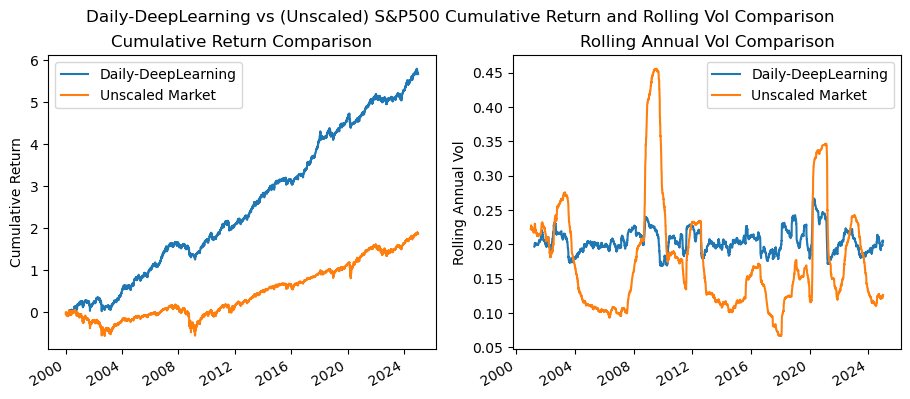

             Daily-DeepLearning Unscaled Market
avg_rtn_ann            0.229242        0.074665
vol_ann                0.205219        0.193884
sharpe_ann             1.117058        0.385098
max_drawdown          -0.363677       -0.567754
CPU times: user 3min 6s, sys: 17.5 s, total: 3min 24s
Wall time: 4min 23s


In [33]:
%%time
## get the ticker list

s3_data_folder = 's3://capstone-general/data-used/' # accident -> two layer of checkpoint4

with fs.open(f'{s3_data_folder}top_200_ticker_l.pkl', 'rb') as f:
    top_200_ticker_l = pickle.load(f)

last_win_only= False
ticker_list = top_200_ticker_l #top_100_ticker_l, top_200_ticker_l, top_300_ticker_l, []
period = 'train_val_test' # train_val, train_val_test, test
scaling_vol_tgt = 0.2
rebal_freq = 'D' # IN mod3

portf_rtn, portf_mkt_rtn, stats_df, scaler_df, fig_perf, scaled_weight_df = \
                            run_dl_for_interface(period, last_win_only, ticker_list, scaling_vol_tgt, verbose=True)


In [27]:
portf_mkt_rtn.cumsum().iloc[-1,:]

Daily-DeepLearning    5.668271
Unscaled Market       1.863650
Name: 2024-12-31 00:00:00, dtype: float64

Getting processed data..
Getting datasets dates..
Getting permno_ticker dic..
Getting predicted return..
Prepare data for opt..
Start opt..
Applying senti scaler..
Producing output for display..


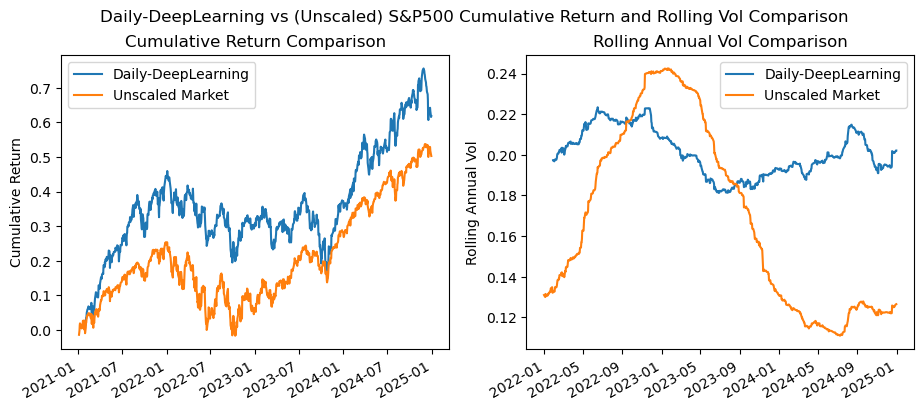

             Daily-DeepLearning Unscaled Market
avg_rtn_ann            0.158099        0.126089
vol_ann                0.200445        0.164996
sharpe_ann             0.788738        0.764193
max_drawdown           -0.29423       -0.254251


In [32]:
%%time
# if run it on a different set of param:
s3_data_folder = 's3://capstone-general/data-used/' # accident -> two layer of checkpoint4

with fs.open(f'{s3_data_folder}top_300_ticker_l.pkl', 'rb') as f:
    top_300_ticker_l = pickle.load(f)

last_win_only= False
ticker_list = [] #top_100_ticker_l, top_200_ticker_l, top_300_ticker_l, []
period = 'test' # train_val, train_val_test, test
scaling_vol_tgt = 0.2
rebal_freq = 'D' # IN mod3

portf_rtn, portf_mkt_rtn, stats_df, scaler_df, fig_perf, scaled_weight_df = \
                            run_dl_for_interface(period, last_win_only, ticker_list, scaling_vol_tgt, verbose=True)


### Test outside of function (for debug purpose)

Getting processed data..
Getting datasets dates..
Getting permno_ticker dic..
Getting predicted return..
Prepare data for opt..
Start opt..
Applying senti scaler..
Producing output for display..


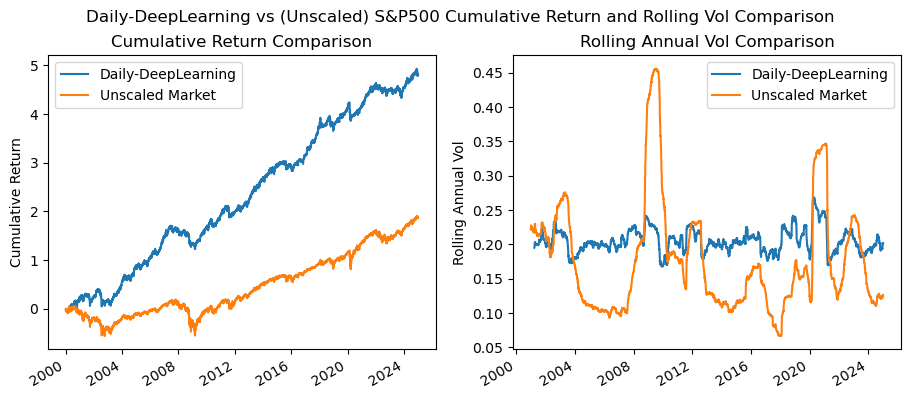

             Daily-DeepLearning Unscaled Market
avg_rtn_ann            0.193873        0.074665
vol_ann                0.205485        0.193884
sharpe_ann             0.943488        0.385098
max_drawdown          -0.409979       -0.567754
CPU times: user 8min 45s, sys: 2min 54s, total: 11min 40s
Wall time: 13min 32s


In [22]:
%%time
'period should be: train_val, train_val_test, test'
'ticker_list should be: top_100_ticker_l, top_200_ticker_l, top_300_ticker_l, []'
verbose = True 
last_win_only= False
ticker_list = [] #top_100_ticker_l, top_200_ticker_l, top_300_ticker_l, []
period = 'train_val_test' # train_val, train_val_test, test
scaling_vol_tgt = 0.2 

if verbose:
    print ('Getting processed data..')
# get background data
s3_folder = 's3://capstone-general/NN-related/dl_model/'
dl_model_checkpoint = 'dl_model_checkpoint0'
rebal_freq = 'D'
dl_model_directory = f'{s3_folder}{dl_model_checkpoint}/{rebal_freq}/'

with fs.open(f'{dl_model_directory}post_process_data_dic.pkl', 'rb') as f:
    post_process_data_dic = pickle.load(f)

# get post processing data
train_val_used = post_process_data_dic['train_val_used']
test_used = post_process_data_dic['test_used'] 
train_used = post_process_data_dic['train_used']
val_used = post_process_data_dic['val_used'] 
train_val_adj = post_process_data_dic['train_val_adj']

train_val_mkt = post_process_data_dic['train_val_mkt']
test_mkt = post_process_data_dic['test_mkt']
train_mkt = post_process_data_dic['train_mkt'] 
val_mkt = post_process_data_dic['val_mkt']

# get dataset
if verbose:
    print ('Getting datasets dates..')
# train_dataset_dl, val_dataset_dl = load_train_val_dataset(dl_model_directory, version_no='10', is_s3=True)
# test_dataset_dl = load_test_dataset(dl_model_directory, version_no='10', is_s3=True)

with fs.open(f'{dl_model_directory}train_dataset_dates_10.pkl', 'rb') as f:
    train_dataset_dates_l = pickle.load(f)

with fs.open(f'{dl_model_directory}val_dataset_dates_10.pkl', 'rb') as f:
    val_dataset_dates_l = pickle.load(f)

with fs.open(f'{dl_model_directory}test_dataset_dates_10.pkl', 'rb') as f:
    test_dataset_dates_l = pickle.load(f)

# get permno_ticker_dic
if verbose:
    print ('Getting permno_ticker dic..')
s3_data_folder = 's3://capstone-general/data-used/' # accident -> two layer of checkpoint4
data_checkpoint = 'data_checkpoint4/data_checkpoint4'
data_directory = f'{s3_data_folder}{data_checkpoint}/'

with fs.open(f'{data_directory}permno_ticker_dic.pkl', 'rb') as f:
    permno_ticker_dic = pickle.load(f)

# get predicted return from model
if verbose:
    print ('Getting predicted return..')
model_filename='model_dl_trf_sm_37'
# display(dl_model_directory)
# display(model_filename)

with fs.open(f'{dl_model_directory}pred_rtn_df_{model_filename}.pkl', 'rb') as f:
    pred_rtn_df = pickle.load(f)

with fs.open(f'{dl_model_directory}pred_rtn_df_test_{model_filename}.pkl', 'rb') as f:
    pred_rtn_df_test = pickle.load(f)

# # for checking
# dl_model_directory_temp='/home/sagemaker-user/user-default-efs/dl_model/dl_model_checkpoint0/D/'
# model_filename='model_dl_trf_sm_37' 

# with open(f'{dl_model_directory_temp}pred_rtn_df_{model_filename}.pkl', 'rb') as f:
#     pred_rtn_df = pickle.load(f)

# with open(f'{dl_model_directory_temp}pred_rtn_df_test_{model_filename}.pkl', 'rb') as f:
#     pred_rtn_df_test = pickle.load(f)

# run through optimization
if verbose:
    print ('Prepare data for opt..')
if len(ticker_list)!=0:
    train_val_used = train_val_used[train_val_used['ticker'].isin(ticker_list)]
    test_used = test_used[test_used['ticker'].isin(ticker_list)]

    filtered_cols = [x for x in pred_rtn_df.columns.tolist() if (not pd.isnull(permno_ticker_dic[x]))\
                            and (permno_ticker_dic[x] in ticker_list)]
    pred_rtn_df = pred_rtn_df[filtered_cols]
    
    
    filtered_cols_test = [x for x in pred_rtn_df_test.columns.tolist() if (not pd.isnull(permno_ticker_dic[x]))\
                            and (permno_ticker_dic[x] in ticker_list)]
    pred_rtn_df_test = pred_rtn_df_test[filtered_cols_test]
    
if period == 'train_val':
    # opt_dataset = train_val_dataset_dl
    opt_dataset_dates = train_dataset_dates_l + val_dataset_dates_l
    opt_date_data_used = train_val_used
    pred_rtn_df_opt = pred_rtn_df
    rolling_ana_data_used = train_val_used
    dates_daily = opt_date_data_used['date'].unique()[20:]
elif period == 'train_val_test':
    # opt_dataset = ConcatDataset([train_val_dataset_dl, test_dataset_dl])
    opt_dataset_dates = train_dataset_dates_l + val_dataset_dates_l + test_dataset_dates_l
    opt_date_data_used = pd.concat([train_val_used, test_used])
    pred_rtn_df_opt = pd.concat([pred_rtn_df, pred_rtn_df_test])
    rolling_ana_data_used = pd.concat([train_val_used, test_used])
    dates_daily = opt_date_data_used['date'].unique()[20:]
elif period == 'test':
    # opt_dataset = test_dataset_dl
    opt_dataset_dates = test_dataset_dates_l
    opt_date_data_used = test_used
    pred_rtn_df_opt = pred_rtn_df_test
    rolling_ana_data_used = test_used
    dates_daily = opt_date_data_used['date'].unique()
else:
    print ('Check the input of period')

if verbose:
    print ('Start opt..')
n_multiple = 252 # (fixed) for annualization
opt_window = 3  # batch_size, window_days
window_days = 128
rebal_freq = 'D' # IN: 'D', 'W', 'M'
opt_flag = 'max_sharpe'  #IN: 'target_risk' or 'max_sharpe'
target_risk = 0.2  #IN: this is an example of 20% annual portfolio risk
 
if last_win_only is True:
    rebal_dates = opt_dataset_dates[-252:]
else:
    rebal_dates = opt_dataset_dates

def opt_t(date, pred_rtn_df, opt_window, dates_daily, rolling_ana_data_used, opt_flag, target_risk, rebal_freq, n_multiple, sim_df=None):
    '''get the rolling period data'''
    index_in_daily_dates = list(dates_daily).index(dates_daily[dates_daily<=date][-1])

    date_period = dates_daily[max(0,(index_in_daily_dates+1)-opt_window*1)
                                :max(opt_window*1, (index_in_daily_dates+1))]
    data_t = rolling_ana_data_used[rolling_ana_data_used['date'].isin(date_period)]

    '''find the appropriate target date in tradeable days'''
    if rebal_freq == 'M':
        match_date = dates_daily[(dates_daily.month==date.month)
                                       &(dates_daily.year==date.year)][-1]
    elif rebal_freq == 'W':
        match_date = dates_daily[(dates_daily<=date)][-1]
    else:
        match_date = date

    ''' optimization'''
    # get the exp return for stocks at rebal date
    temp_rtn = pred_rtn_df_opt.loc[match_date,:]
    exp_exc_rtn_t = temp_rtn.where([len(str(x))==5 for x in temp_rtn.index], np.nan).dropna().to_frame().T

    try:
        return_data = data_t[['date','permno']+['prev_d_exc_ret']]\
            .groupby(['date','permno'])['prev_d_exc_ret'].last().unstack()[exp_exc_rtn_t.columns].replace(np.nan, 0)
    except KeyError:
        print (match_date)
        print ('adjust columns')
        intersect_cols= list(set(data_t['permno'].unique()).intersection(set(exp_exc_rtn_t.columns.tolist())))
        return_data = data_t[['date','permno']+['prev_d_exc_ret']]\
            .groupby(['date','permno'])['prev_d_exc_ret'].last().unstack()[intersect_cols].replace(np.nan, 0)
        exp_exc_rtn_t = exp_exc_rtn_t[intersect_cols]
                         
    if sim_df is None:
        p = LedoitWolf().fit(return_data).covariance_
        p += np.eye(p.shape[0])*1e-8 # add small number to incerase numerical stability
        cov_matrix = risk_models.fix_nonpositive_semidefinite(
            pd.DataFrame(p,
                     index=return_data.columns, columns=return_data.columns)*n_multiple, fix_method='spectral')
        # fix_method: {"spectral", "diag"}, defaults to "spectral"
    else: 
        sim_t = sim_df.loc[match_date] 
        sim_t = sim_t[sim_t.index] #only obtain the stocks exists that day
        coeff_matrix = np.array(sim_t)
        
        vol = np.array(return_data.std()) 
        # print (vol.shape) 
        vol_matrix = np.diag(vol) 

        p = vol_matrix @ coeff_matrix @ vol_matrix
        p += np.eye(p.shape[0])*1e-8 # add small number to incerase numerical stability
        cov_matrix = risk_models.fix_nonpositive_semidefinite(
            pd.DataFrame(p,
                     index=return_data.columns, columns=return_data.columns)*n_multiple, fix_method='spectral')
    
    opt_w_ef = optimizer_ef(exp_exc_rtn_t.squeeze()*n_multiple, cov_matrix, opt_flag, target_risk,
                 solver_name='CLARABEL', market_neutral=False, risk_free_rate=None)  
    # IN: if has value error complaining exp return all below risk free rate, could set risk free rate to zero here
    #IN: note the optimizer requires the expected return being series/array
    opt_w_t = pd.DataFrame(opt_w_ef, index=[date])

    return exp_exc_rtn_t, opt_w_t

# Run in parallel
## IN: note the results from the parallel processing has to be just one list of result
# at each t, which could be a tuple of different results at each time t
# sim_df = sim_df # sim_df or None

res_list = Parallel(n_jobs=-1)(delayed(
    opt_t)(date, pred_rtn_df, opt_window, dates_daily, rolling_ana_data_used, opt_flag, target_risk, \
           rebal_freq, n_multiple, sim_df=None)
    for date in rebal_dates
)

# Organize the results
exp_exc_rtn_df = pd.concat([res_t[0] for res_t in res_list])
opt_weight_df = pd.concat([res_t[1] for res_t in res_list])

# Apply senti score filter
if verbose:
    print ('Applying senti scaler..')
opt_weight_df_0 = opt_weight_df.copy()

senti_score_used = rolling_ana_data_used[['date','senti_score']].set_index('date').drop_duplicates()\
        .reindex(opt_weight_df.index)

senti_scale = senti_score_used['senti_score'].ewm(com=2).mean().apply(lambda x: 1.1 if x>0.6 else 0.9 if x<0.4 else 1)

opt_weight_df = opt_weight_df_0.mul(senti_scale, axis=0)

# produce results
if verbose:
    print ('Producing output for display..')
if period == 'train_val':
    mkt_data_used = train_val_mkt
elif period == 'train_val_test':
    mkt_data_used = pd.concat([train_val_mkt, test_mkt])
elif period == 'test':
    mkt_data_used = test_mkt
else:
    print('Check period input!')

portf_rtn, portf_mkt_rtn, stats_df, scaler_df, fig_perf = \
portfolio_performance(rolling_ana_data_used, opt_weight_df, 'Daily-DeepLearning', 'D', mkt_data_used, \
                      last_win_only=last_win_only, vol_scaler_flag=True, scaling_vol_tgt=0.2, plot_show=True)

scaled_weight_df = opt_weight_df.multiply(scaler_df, axis=0).rename(columns=permno_ticker_dic)

# combine columns with the same name - given the same ticker may have different permno over time
scaled_weight_df = scaled_weight_df.T.groupby(by=scaled_weight_df.columns).sum().T


### Consolidate results with BM and produce plot and stats table

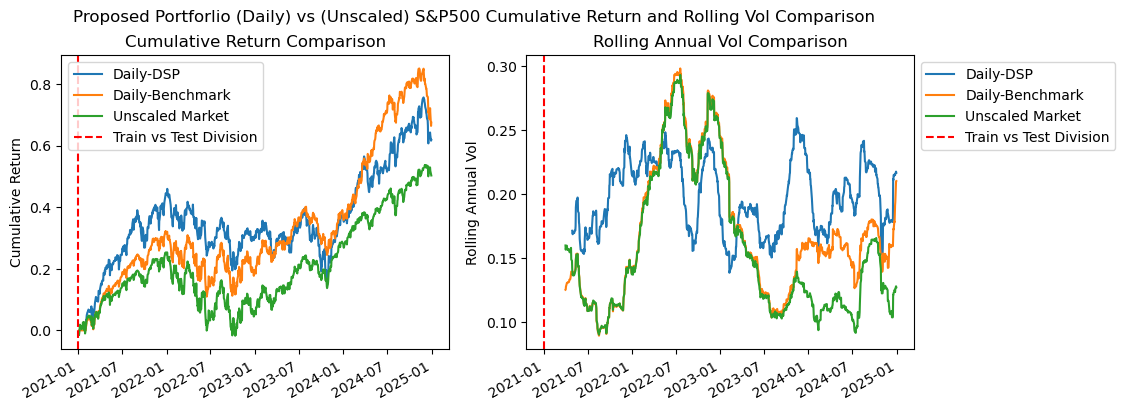

             Daily-DSP Daily-Benchmark Unscaled Market
avg_rtn_ann   0.158099        0.169132        0.126089
vol_ann       0.200445        0.177682        0.164996
sharpe_ann    0.788738         0.95188        0.764193
max_drawdown  -0.29423       -0.206317       -0.254251


In [8]:
# consolidate results with benchmark:
# assume we obtain the benchmark results from previous run:
s3_bm_res_folder = 's3://capstone-general/benchmark_model/bm_res_for_ref/'
bm_res_file_name = 'bm_res_dic_comb.pkl'
# Note: this bm file is for the full universe, put here to test the pipe; 
# in formal setting, make sure to run both bm and ml for the same universe, and for the same period 
# (most likely: test, last_win_only=True or False)

with fs.open(f'{s3_bm_res_folder}{bm_res_file_name}', 'rb') as f:
    bm_res_dic_used = pickle.load(f)

# adjust to align dates (if bm and dl are produced with consistent setting this step is optional)
portf_rtn_bm = bm_res_dic_used['portf_rtn'].reindex(portf_rtn.index).fillna(0)

# DL without senti vs bm, mkt
rebal_freq_plot = 'Daily' if rebal_freq == 'D' else 'Weekly' if rebal_freq == 'W' else 'Monthly'
opt_flag_plot = 'Max_Sharpe'

ml_portf_name = f'{rebal_freq_plot}-DSP'
bm_portf_name = f'{rebal_freq_plot}-Benchmark'

portf_rtn_df_l, mkt_rtn = [portf_rtn.rename(ml_portf_name), 
                           portf_rtn_bm.rename(bm_portf_name)], \
                                portf_mkt_rtn['Unscaled Market']

portf_mkt_rtn_comb, stats_df_comb, fig_comb = performance_comparison_all_recal(portf_rtn_df_l, mkt_rtn, \
                rebal_freq=rebal_freq_plot, last_win_only=last_win_only, plot_show=True)

### Save results from ML and model comparison

In [9]:
# prepare results to be saved
dl_res_dic_deploy = {
    'portf_rtn':portf_rtn, 
    'portf_mkt_rtn': portf_mkt_rtn, 
    'stats_df': stats_df, 
    'scaler_df': scaler_df, 
    'fig_perf': fig_perf, 
    'scaled_weight_df': scaled_weight_df
}

comb_res_dic_deploy = {
    'portf_mkt_rtn': portf_mkt_rtn_comb,
    'stats_df': stats_df_comb,
    'fig_perf': fig_comb,
}

s3_dl_res_deploy_folder = 's3://capstone-general/NN-related/dl_model_res_deploy/'
# Note: this file is for the full universe, put here to test the pipe; in formal setting, 
# make sure to run both bm and ml for the same universe, and for the same period

with fs.open(f'{s3_dl_res_deploy_folder}dl_res_dic_deploy.pkl', 'wb') as f:
    pickle.dump(dl_res_dic_deploy, f)

with fs.open(f'{s3_dl_res_deploy_folder}comb_res_dic_deploy.pkl', 'wb') as f:
    pickle.dump(comb_res_dic_deploy, f)